# FFT sample

In [1]:
import pycuda.gpuarray as gpuarray
from pycuda.autoinit import context
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
dev=cuda.Device(1)
dev.make_context()

import util.RotRep as Rot

from scipy.ndimage import gaussian_filter

In [2]:
def totalSim(XD,YD,OffsetD,MaskD,TrueMaskD,
             x15D,y15D,recon,S15D,NumD,NumG,
             dJ=0,dK=0,dD=0,dT=np.eye(3),dE=0):
    recon.ResetDet()
    recon.MoveDet(dJ,dK,dD,dT)
    BlockSize=256
    scoreD=gpuarray.empty(NumD,dtype=np.float32)
    recon.sim_grain(XD,YD,OffsetD,MaskD,TrueMaskD,
                        x15D, y15D,recon.afDetInfoD,S15D,
                        recon.whichOmegaD,np.int32(NumD),np.int32(NumG),np.float32(recon.eng+dE),np.int32(45),recon.LimD,np.int32(5),
                         block=(recon.NumG,1,1),grid=(NumD,1))
    
    recon.ResetDet()
    
    XH=XD.get()
    YH=YD.get()
    OH=OffsetD.get()
    xtmp=XH.reshape((-1,NumG))
    ytmp=YH.reshape((-1,NumG))
    otmp=OH.reshape((-1,NumG))

    return xtmp,ytmp,otmp

In [13]:
import numpy as np
x15=np.load('/home/yufengs/SimData/g40_fac40/x.npy')
y15=np.load('/home/yufengs/SimData/g40_fac40/y.npy')
S15=np.load('/home/yufengs/SimData/g40_fac40/allMaxS.npy')

In [15]:
import h5py
a=h5py.File('/home/yufengs/SimData/grain_40_fac40.hdf5')
Lim=np.array(a['limits'])

In [16]:
from InitStrain import Initializer
from Reconst_GPU import StrainReconstructor_GPU
Cfg=Initializer('ConfigFiles/g40.yml')
Cfg.SetPosOrien(a['Pos'],a['Orien'])
Cfg.Simulate()
recon=StrainReconstructor_GPU( _NumG=Cfg.NumG,
        peakFile=a,
        _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
recon.loadGs()

In [17]:
NumD=len(x15)

S15D=gpuarray.to_gpu(S15.ravel().astype(np.float32))

XD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)
YD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)
OffsetD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.int32)

MaskD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.bool_)
TrueMaskD=gpuarray.empty(Cfg.NumG*NumD,dtype=np.bool_)

<IPython.core.display.Javascript object>


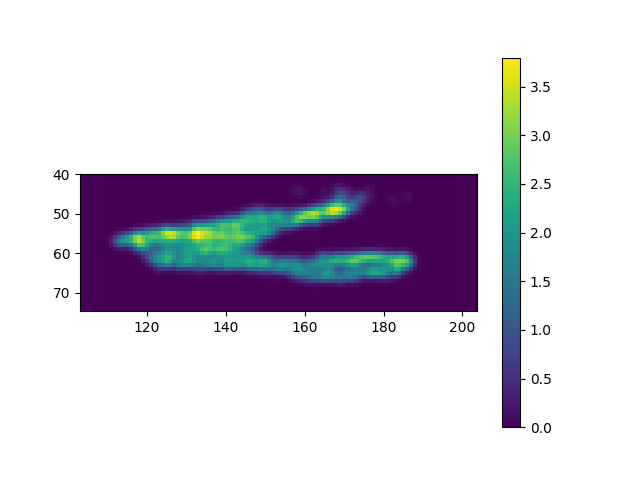

In [18]:
from collections import Counter
from scipy.sparse import coo_matrix
ii=2
mymap=np.zeros((Lim[ii][3]-Lim[ii][2],Lim[ii][1]-Lim[ii][0]))



x15Dtmp=gpuarray.to_gpu((x15).astype(np.float32))
y15Dtmp=gpuarray.to_gpu((y15).astype(np.float32))

xtmp,ytmp,otmp=totalSim(XD,YD,OffsetD,MaskD,TrueMaskD,
                        x15Dtmp,y15Dtmp,recon,S15D,NumD,recon.NumG)

idx=np.where(otmp[:,ii]==13)[0]

myCounter=Counter(zip(xtmp[idx,ii],ytmp[idx,ii]))
val=list(myCounter.values())
xx,yy=zip(*(myCounter.keys()))

mymap=mymap+coo_matrix((val,(yy,xx)),shape=(Lim[ii][3]-Lim[ii][2],Lim[ii][1]-Lim[ii][0])).toarray()

import matplotlib.pyplot as plt
%matplotlib notebook
plt.imshow(gaussian_filter(mymap,sigma=1,mode='nearest',truncate=4))
plt.colorbar()
plt.show()